# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [49]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [50]:
# Loading the general population data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv')

C:\Users\jobqu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [51]:
# Removing first column (noise)
azdias.drop(azdias.columns[0], axis = 1, inplace = True)

# Taking a look at the data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [52]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv')

C:\Users\jobqu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [53]:
# Removing first column (noise)
customers.drop(customers.columns[0], axis = 1, inplace = True)

# Taking a look at the data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**Loading attribute description files**

These files can be manually opened to consult the meaning of attribute values. However, it can also be used to automate some tasks. In particular, we can find out which values are supposed to be missing or unknown values. 

By using info_levels we can also understand which class of information (personal, financial, location) is more relevant (without managing extremely-specific attribute labels)

In [54]:
attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header = 1).drop('Unnamed: 0', axis = 1)
info_levels = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header = 1).drop('Unnamed: 0', axis = 1)
#attributes.head()

### 0.1 Addressing the warnings

While loading the data we got a warning about column 19 and 20 (now 18 and 19 because we removed 1 column) having mixed types. While this can be handle in the preprocessing section we will fix the issue now, before continuing knowing the data.

**Column 18**

In [55]:
# Name of columns
print(azdias.columns[18], customers.columns[18])

CAMEO_DEUG_2015 CAMEO_DEUG_2015


The attribute CAMEO_DEUG_2015 is supposed to have only numerical (integer) attributes. The description even includes a numberic code for unknown values (-1). 

However, if we display the unique values for this column we see:

In [56]:
# Finding unique values
print('Unique values in azdias:', azdias.iloc[:, 18].unique() )

print('Unique values in  customers:', customers.iloc[:, 18].unique() )

Unique values in azdias: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
Unique values in  customers: [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']


We can clearly see that the attribute has mixed type values. We can solve this issue by casting the strings containing a number and assigning `nan` to the 'X' string:

In [57]:
azdias.iloc[:,18] = azdias.iloc[:,18].replace({'X': np.nan})
customers.iloc[:,18] = customers.iloc[:,18].replace({'X': np.nan})

# Casting
azdias.iloc[:, 18] = azdias.iloc[:, 18].map(float)
customers.iloc[:, 18] = customers.iloc[:, 18].map(float)

**Final result:**

In [58]:
# Finding unique values
print('Final unique values in azdias:', azdias.iloc[:, 18].unique() )

print('Final unique values in  customers:', customers.iloc[:, 18].unique() )

Final unique values in azdias: [nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]
Final unique values in  customers: [ 1. nan  5.  4.  7.  3.  9.  2.  6.  8.]


We can repeat the same process for **column 19**:

In [59]:
# Name of column
print( azdias.columns[19], customers.columns[19] )

CAMEO_INTL_2015 CAMEO_INTL_2015


By looking at the attributes descriptions the attribute called 'CAMEO_INTL_2015' does not appear, the closest attribute name is 'CAMEO_DEUINTL_2015'. This is probably a typo, either in the description files or within the datasets. 

In [60]:
attributes['Attribute'].unique()[11:15]

array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015',
       'CJT_GESAMTTYP'], dtype=object)

Just like the previous attribute, CAMEO_DEUNTL_2015 is also supposed to have only numerical (integer) attributes. If we display the unique values of this column we see: 

In [61]:
print('Unique values in azdias:', azdias.iloc[:, 19].unique() )
print('\nUnique values in customers:', customers.iloc[:, 19].unique() )

Unique values in azdias: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']

Unique values in customers: [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


By applying the same steps as before:

In [62]:
azdias.iloc[:,19] = azdias.iloc[:,19].replace({'XX': np.nan})
customers.iloc[:,19] = customers.iloc[:,19].replace({'XX': np.nan})

azdias.iloc[:, 19] = azdias.iloc[:, 19].map(float)
customers.iloc[:, 19] = customers.iloc[:, 19].map(float)

**Final result:**

In [63]:
print('Final unique values in azdias:', azdias.iloc[:, 19].unique() )
print('\nFinal unique values in customers:', customers.iloc[:, 19].unique() )

Final unique values in azdias: [nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.]

Final unique values in customers: [13. nan 34. 24. 41. 23. 15. 55. 14. 22. 43. 51. 33. 25. 44. 54. 32. 12.
 35. 31. 45. 52.]


### 0.2 Missing values (part 1)

Before start analyzing the distribution of the data, we are going to drop the columns with a high number of missing values (>50%). At first, there seems to be only 6 columns like that for the `azdias dataset, and 7 columns for the `customers` dataset: 

Overall missing values: 33493669


<AxesSubplot:>

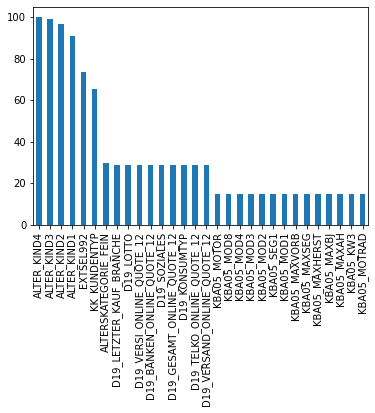

In [64]:
azdias_missing_values_1 = azdias.isnull().sum()
percentage_missing_values_1 = azdias_missing_values_1.sort_values(ascending = False) / azdias.shape[0] * 100

print('Overall missing values:', azdias_missing_values_1.sum())

# Plotting Top 30 features with missing values
percentage_missing_values_1[:30].plot.bar()

For the customers dataset:

Overall missing values: 13864774


<AxesSubplot:>

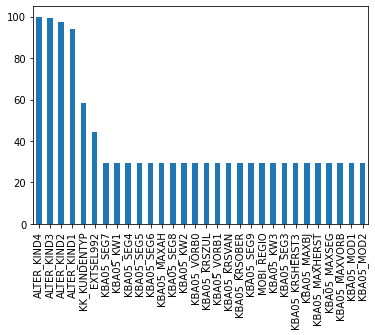

In [65]:
customers_missing_values_1 = customers.isnull().sum()
percentage_missing_values_1 = customers_missing_values_1.sort_values(ascending = False) / customers.shape[0] * 100

print('Overall missing values:', customers_missing_values_1.sum())

# Plotting Top 30 features with missing values
percentage_missing_values_1[:30].plot.bar()

This graphs shows that six features have a high number of missing values (more than 50%), however, there are still more missing values in the dataset, because some row values are actually indicating unknown values. 

The next step for cleaning the data is to replace `np.nan` in the values indicating `unknown` information. But before replacing values we have to create a DataFrame where each attribute is associated with values indicating missing information. We also are going to add the `information level` field to each attribute.

In [66]:
# Taking a look to the attributes dataframe
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [67]:
info_levels.head()

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


We would like to have a single table with the following columns: 

|Attribute|Information level| Description| Null values |
|-------- | --------------- | -----------| ---------------|
|AGER_TYP |Person          | best-ager typology  | [-1, 0, np.nan] |




In [68]:
# Step 1: Forward fill the 'Information level' column in the info_level dataframe, 
#         and the 'Attribute' and 'Meaning' columns in the attributes dataframe

info_levels['Information level'] = info_levels['Information level'].ffill()
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes['Meaning'] = attributes['Meaning'].ffill()

In [69]:
# Step 2: For each attribute, find the value for missing information.
# We are going to search for values where the meaning is "unknown"
pattern = r'unknown'
missing_codes = attributes[attributes['Meaning'].str.contains(pattern, flags = re.I)]

# also, drop the 'Meaning' column
missing_codes = missing_codes[['Attribute', 'Description', 'Value']]
missing_codes.rename(columns = {'Value': 'Missing values code'}, inplace = True)
missing_codes.head()

,Attribute,Description,Missing values code
0,AGER_TYP,best-ager typology,-1
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0"
11,ALTER_HH,main age within the household,0
33,ANREDE_KZ,gender,"-1, 0"
40,BALLRAUM,distance to next urban centre,-1


In [70]:
# Step 3: We are going to find those attributes which values do not match the previous searching patterns
all_attributes = set(attributes['Attribute'].unique())
selected_attributes = set(missing_codes['Attribute'].unique())

# Set of attributes without a code for missing values
no_code = list(all_attributes - selected_attributes)

no_code[:5]

['D19_GESAMT_ONLINE_DATUM',
 'D19_LEBENSMITTEL_RZ',
 'D19_BUCH_RZ',
 'D19_TELKO_ONLINE_DATUM',
 'D19_GARTEN_RZ']

By manually inspecting each of this attributes we make sure that they indeed do not have a specific value for missing values, with many of them being numerical values.

In [71]:
# Step 4: Adding the attributes without a missing code
#attributes[attributes['Attribute'].isin(no_code) and attributes['Description'].notnull()]

for attr in no_code:
    temp_df = attributes[attributes['Attribute'] == attr]
    row = temp_df.iloc[0, 0:2]
    missing_codes = missing_codes.append(row)
    
missing_codes.sort_index(inplace = True)

In [72]:
def str2list(string):
    """Receives a string in the form: '-1, 0'
    and returns a list like [-1, 0]"""
    if type(string) == str:
        aux = string.split(', ')
        return [int(x) for x in aux]
    elif type(string) == int: # already an integer
        return string
    elif np.isnan(string):
        return string
    else:
        print('Weird case: ', string)
        assert False

In [73]:
# Step 5: Converting the 'Value' column to lists and adding the 'information level' column to each attribute
missing_codes['Missing values code'] = missing_codes['Missing values code'].map(str2list)

In [74]:
missing_codes['Missing values code']

0            -1
5       [-1, 0]
11            0
33      [-1, 0]
36          NaN
         ...   
2219    [-1, 0]
2229         -1
2238    [-1, 0]
2244    [-1, 0]
2251    [-1, 9]
Name: Missing values code, Length: 314, dtype: object

**Replacing code for missing values** in the `azdias` and the `customers` dataframes.

In [75]:
# Set the 'Attribute' column as index. This would reduce the lenght of the following code
missing_codes.set_index('Attribute', inplace = True)

for att in missing_codes.index:
    code = missing_codes.loc[att, 'Missing values code']
    if type(code) in [int, list]:
        try:   #Some attributes do not appear in the actual dataframes...
            azdias[att] = azdias[att].replace(code, np.nan)
            customers[att] = customers[att].replace(code, np.nan)
        except:
            continue

In [76]:
# Finally we add the 'Information level' column by merging dataframes

#Join by index
info_levels.set_index('Attribute', inplace = True)

In [77]:
attributes_info = pd.merge(left = missing_codes, right = info_levels['Information level'], how = 'left', left_index = True, right_index = True)

In [78]:
attributes_info

,Description,Missing values code,Information level
Attribute,,,
AGER_TYP,best-ager typology,-1,Person
ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",Person
ALTER_HH,main age within the household,0,Household
ANREDE_KZ,gender,"[-1, 0]",Person
ANZ_HAUSHALTE_AKTIV,number of households in the building,NaN,Building
...,...,...,...
WOHNDAUER_2008,length of residence,"[-1, 0]",Household
WOHNLAGE,residential-area,-1,Building
WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"[-1, 0]",Microcell (RR3_ID)


### Comparing the percentage of missing values

Now that the codes for missing values are recognized as such, we can proceed to count again the number of missing values.

Overall missing values: 37088263 
Additional missing values: 3594594


<AxesSubplot:>

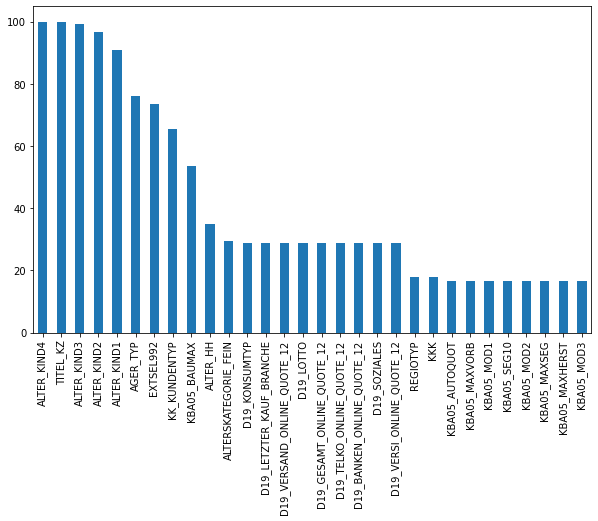

In [79]:
azdias_missing_values = azdias.isnull().sum()
percentage_missing_values = azdias_missing_values.sort_values(ascending = False) / azdias.shape[0] * 100

print('Overall missing values:', azdias_missing_values.sum(),
      '\nAdditional missing values:', azdias_missing_values.sum() - azdias_missing_values_1.sum() )

# Plotting Top 30 features with missing values
plt.figure(figsize = (10, 6))
percentage_missing_values[:30].plot.bar()

Overall missing values: 14488721 
Additional missing values: 623947


<AxesSubplot:>

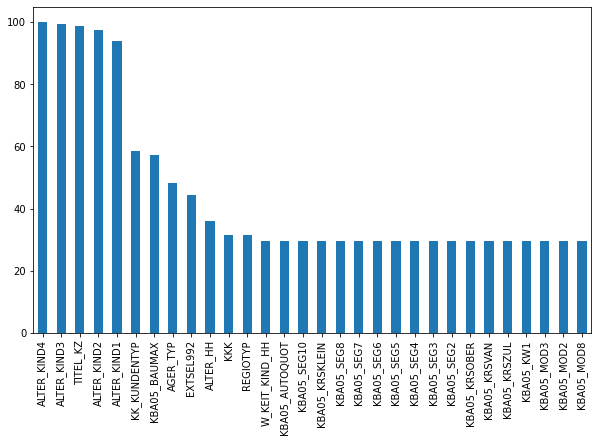

In [80]:
customers_missing_values = customers.isnull().sum()
percentage_missing_values = customers_missing_values.sort_values(ascending = False) / customers.shape[0] * 100

print('Overall missing values:', customers_missing_values.sum(),
      '\nAdditional missing values:', customers_missing_values.sum() - customers_missing_values_1.sum() )

# Plotting Top 30 features with missing values
plt.figure(figsize = (10, 6))
percentage_missing_values[:30].plot.bar()

The number of missing values increase with respect to the original dataset (by 3,594,594 in `azdias` and in `customers`). According to the plot above, we now have 9 columns with more than 40% missing values. These columns will be eliminated from the dataset:

- `ALTER_KIND1-4`: No description found
- `TITEL_KZ`: "*Flag wheter a person holds an academic title*"
- `AGER_TYP`: "*Best-ager typology"*. Besides, there are other features regarding the age of the subjects.
- `EXTSEL992`: No description found
- `KK_KUNDENTYP`: No description found
- `KBA05_BAUMAX`: Most common building-type within the cell

#### Dropping the columns

In [81]:
attributes_info

,Description,Missing values code,Information level
Attribute,,,
AGER_TYP,best-ager typology,-1,Person
ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",Person
ALTER_HH,main age within the household,0,Household
ANREDE_KZ,gender,"[-1, 0]",Person
ANZ_HAUSHALTE_AKTIV,number of households in the building,NaN,Building
...,...,...,...
WOHNDAUER_2008,length of residence,"[-1, 0]",Household
WOHNLAGE,residential-area,-1,Building
WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"[-1, 0]",Microcell (RR3_ID)


In [82]:
attributes_info.drop( ['TITEL_KZ', 'AGER_TYP', 'KBA05_BAUMAX'], axis = 0, inplace = True)

azdias.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                'TITEL_KZ', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)

customers.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                'TITEL_KZ', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)

## Feature engineering

### Distribution of attributes

The following graph shows the distribution of the type of attributes in the datasets.

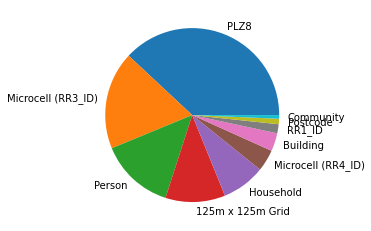

In [83]:
# Plot of number of features per information level  (pie)
att_per_infolevel = attributes_info.reset_index().groupby('Information level').count().sort_values(by = 'Attribute', ascending = False)

att_per_infolevel['Attribute'].plot.pie()
plt.ylabel('');

### PLZ8

The `PLZ8` type of attribute is clearly the most common one. 

Within the `PLZ8` class of attributes there are attributes starting with `'KBA'` which refer to the share of cars with very specific characteristics (too specific...). This attributes will be discarded for our analysis, because, even though the characteristics of cars can provide financial information, we have other attributes with more clear financial information. 

In [84]:
columns_to_drop = list(attributes_info[attributes_info['Information level'] == 'PLZ8'].iloc[:-7].index) + list(attributes_info[attributes_info['Information level'] == 'PLZ8'].iloc[-3:].index)

columns_to_drop = list( set(columns_to_drop).intersection(set(customers.columns)) )

customers.drop(columns_to_drop, axis = 1, inplace = True)
azdias.drop(columns_to_drop, axis = 1, inplace = True)

The attributes `PLZ8_ANTG1-4` provide information about family houses in a certain zone, this information can be interesting for our analysis and therefore they will be keep. The missing values in such columns will be imputed with the most frequent value.

In [85]:
for col in ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4']:
    customers[col].fillna(customers[col].mode().values[0], inplace = True)
    azdias[col].fillna(azdias[col].mode().values[0], inplace = True)

### Microcell (RR3_ID)

This type of attributes also accounts for very specific information about the cars of certain area. We will also drop these columns for our analysis.

In [86]:
columns_to_drop = list(attributes_info[attributes_info['Information level'] == 'Microcell (RR3_ID)'].iloc[:-7].index)

customers.drop(columns_to_drop, axis = 1, inplace = True)
azdias.drop(columns_to_drop, axis = 1, inplace = True)

## Person

This class of attributes will probably be one of the most relevant ones, because it includes personal information like age, health, social and financial status, and others. 

Since this features will probably be very useful for our predictions we are going to carefully engineer each feature.


In [87]:
attributes_info[attributes_info['Information level'] == 'Person']

,Description,Missing values code,Information level
Attribute,,,
ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",Person
ANREDE_KZ,gender,"[-1, 0]",Person
CJT_GESAMTTYP,customer journey typology,0,Person
FINANZTYP,best descirbing financial type for the person,-1,Person
FINANZ_ANLEGER,financial typology: investor,-1,Person
FINANZ_HAUSBAUER,financial typology: main focus is the own house,-1,Person
FINANZ_MINIMALIST,financial typology: low financial interest,-1,Person
FINANZ_SPARER,financial typology: money saver,-1,Person
FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-1,Person


#### ALTERSKATEGORIE_GROB

*Age classification through prename analysis*

Ordinal variable. Can be left as it is. Missing values will be replaced by 0's

In [88]:
customers['ALTERSKATEGORIE_GROB'].fillna(0, inplace = True)
azdias['ALTERSKATEGORIE_GROB'].fillna(0, inplace = True)

#### ANREDE_KZ 

*Gender*

Categorical variable but already codified as numerical.
This column does not have missing values. It is left as it is.

#### CJT_GESAMTTYP

*Customer journey typology*

Categorical variable, we will define a replace dictionary to keep the category names.

In [89]:
customers['CJT_GESAMTTYP'].replace({1: 'Advert and consum minimalist', 
                                    2: 'Advert and consum traditionalist',
                                    3: 'Advert interested store-shopper',
                                    4: 'Advert interested online-shopper',
                                    5: 'Advert and cross-channel enthusiast', 
                                    6: 'Advert ethusiast with restricted cross-channel'},
                                   inplace = True)

azdias['CJT_GESAMTTYP'].replace({1: 'Advert and consum minimalist', 
                                    2: 'Advert and consum traditionalist',
                                    3: 'Advert interested store-shopper',
                                    4: 'Advert interested online-shopper',
                                    5: 'Advert and cross-channel enthusiast', 
                                    6: 'Advert ethusiast with restricted cross-channel'},
                                   inplace = True)

# Percentage of missing values
print(customers['CJT_GESAMTTYP'].isnull().sum() / customers.shape[0] )

azdias['CJT_GESAMTTYP'].isnull().sum() / azdias.shape[0] 

0.016764761129547303


0.005446460529992

Since it has very few missing values (< 2%) we will fill nan values with the most common value ('Advert enthusiast with restricted cross-channel bhv')

In [90]:
customers['CJT_GESAMTTYP'].fillna(customers['CJT_GESAMTTYP'].mode().iloc[0], inplace = True)
azdias['CJT_GESAMTTYP'].fillna(azdias['CJT_GESAMTTYP'].mode().iloc[0], inplace = True)

Converting to dummy variables

In [91]:
customers['CJT_GESAMTTYP']

0                    Advert and cross-channel enthusiast
1         Advert ethusiast with restricted cross-channel
2                       Advert and consum traditionalist
3                       Advert and consum traditionalist
4         Advert ethusiast with restricted cross-channel
                               ...                      
191647                  Advert interested online-shopper
191648                  Advert and consum traditionalist
191649                  Advert and consum traditionalist
191650                  Advert interested online-shopper
191651                  Advert and consum traditionalist
Name: CJT_GESAMTTYP, Length: 191652, dtype: object

In [92]:
customers = pd.get_dummies(customers, columns = ['CJT_GESAMTTYP'])
azdias = pd.get_dummies(azdias, columns = ['CJT_GESAMTTYP'])

### FINANZ_ ... 

- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_VORSORGER
- FINANZ_ANLEGER
- FINANZ_UNAUFFAELLIGER
- FINANZ_HAUSBAUER
- FINANZTYP

These features refer to the financial typology of the individuals. They are probably of high importance. 

All of this variables are ordinal, we don't have to create dummy variables because they can be use numerically. 

We fill missing values with the previous valid value (there are no missing values, in this case)

In [93]:
customers[['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 
           'FINANZTYP']] = customers[['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 
                                       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 
                                       'FINANZTYP']].fillna(method='ffill')

azdias[['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 
           'FINANZTYP']] = azdias[['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 
                                   'FINANZTYP']].fillna(method='ffill')

### GEBURTSJAHR

This column is also pretty important because it represents the year of birth, from which we can extract the age by substracting it from the current year:

In [223]:
customers['GEBURTSJAHR'].replace(0, np.nan, inplace = True)
azdias['GEBURTSJAHR'].replace(0, np.nan, inplace = True)

# We create a new column for the age feature
customers['ALTER'] = 2021 - customers['GEBURTSJAHR']
azdias['ALTER'] = 2021 - azdias['GEBURTSJAHR']

Unfortunately there are many missing values:

In [224]:
print('Missing values in customers: {}, around a {}%'.format( customers['ALTER'].isnull().sum(), 
                                                              round(100 * customers['ALTER'].isnull().sum() / customers.shape[0], 2)))

print('Missing values in azdias: {}, around a {}%'.format( azdias['ALTER'].isnull().sum(), 
                                                              round(100 * azdias['ALTER'].isnull().sum() / azdias.shape[0], 2)))

Missing values in customers: 93024, around a 48.54%
Missing values in azdias: 392318, around a 44.02%


But we can use the previously preprocessed column `ALTERSKATEGORIE_GROB` to approximate the age of the subjects...

In [225]:
# But first, we have to replace the value '9' in this column by the most frequent value... 
customers['ALTERSKATEGORIE_GROB'].replace(9, customers['ALTERSKATEGORIE_GROB'].mode().iloc[0], inplace = True)

azdias['ALTERSKATEGORIE_GROB'].replace(9, azdias['ALTERSKATEGORIE_GROB'].mode().iloc[0], inplace = True)

Then we can impute a value for the age by multiplying for the approximate age from the name analysis

In [226]:
customers['ALTER'].mask( customers['ALTER'].isnull(), customers['ALTERSKATEGORIE_GROB'] * 17, inplace = True)

azdias['ALTER'].mask( azdias['ALTER'].isnull(), azdias['ALTERSKATEGORIE_GROB'] * 17, inplace = True)

We verify that there are no missing values and we can see the final distribution.

0


count    191652.000000
mean         58.502291
std          22.065246
min           4.000000
25%          51.000000
50%          66.000000
75%          74.000000
max         121.000000
Name: ALTER, dtype: float64

<AxesSubplot:>

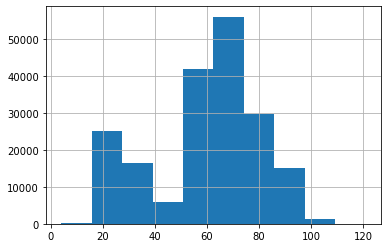

In [227]:
print(customers['ALTER'].isnull().sum())

display(customers['ALTER'].describe())

customers['ALTER'].hist()

0


count    891221.000000
mean         50.992982
std          17.735025
min           4.000000
25%          37.000000
50%          51.000000
75%          67.000000
max         121.000000
Name: ALTER, dtype: float64

<AxesSubplot:>

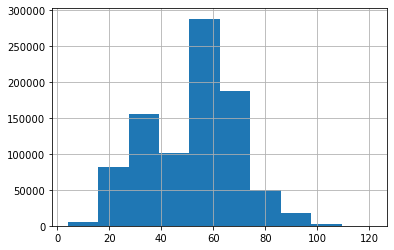

In [228]:
print(azdias['ALTER'].isnull().sum())

display(azdias['ALTER'].describe())

azdias['ALTER'].hist(bins = 10)

The new `ALTER` column includes information from `GEBURTSJAHR` and `ALTERSKATEGORIE_GROB`, we can verify this in the correlation matrix. We are going to drop the `GEBURTSJAHR` and `ALTERSKATEGORIE_GROB` columns.

In [236]:
customers[['ALTER', 'GEBURTSJAHR', 'ALTERSKATEGORIE_GROB']].corr()

,ALTER,GEBURTSJAHR,ALTERSKATEGORIE_GROB
ALTER,1.000000,-1.000000,0.820652
GEBURTSJAHR,-1.000000,1.000000,-0.406778
ALTERSKATEGORIE_GROB,0.820652,-0.406778,1.000000


In [237]:
azdias[['ALTER', 'GEBURTSJAHR', 'ALTERSKATEGORIE_GROB']].corr()

,ALTER,GEBURTSJAHR,ALTERSKATEGORIE_GROB
ALTER,1.000000,-1.000000,0.769892
GEBURTSJAHR,-1.000000,1.000000,-0.631582
ALTERSKATEGORIE_GROB,0.769892,-0.631582,1.000000


In [238]:
customers.drop(['GEBURTSJAHR', 'ALTERSKATEGORIE_GROB'], axis = 1, inplace = True)

azdias.drop(['GEBURTSJAHR', 'ALTERSKATEGORIE_GROB'], axis = 1, inplace = True)

#### Reading files so far...

In [295]:
customers = pd.read_csv('customers_prc.csv')
customers.drop(['Unnamed: 0'], axis = 1, inplace = True)

azdias = pd.read_csv('azdias_prc.csv')
azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)

#### GFK_URLAUBERTYP

*Vacation habits*

This feature might probably not be related with the goal, and since it is a categorical variable with several options we are going to drop it...

In [296]:
customers.drop(['GFK_URLAUBERTYP'], axis = 1, inplace = True)

azdias.drop(['GFK_URLAUBERTYP'], axis = 1, inplace = True)

#### GREEN_AVANTGARDE

A binary categorical variable without missing values, no processing needed, we keep it.

#### HEALTH_TYP

*Health typology*

Categorical variable with a reasonably low impact and with plenty of missing values. We drop it


In [297]:
customers.drop(['HEALTH_TYP'], axis = 1, inplace = True)

azdias.drop(['HEALTH_TYP'], axis = 1, inplace = True)

#### LP_LEBENSPHASE_FEIN & LP_LEBENSPHASE_GROB

Attribute related to family income, probably a relevant feature. 

Both attributes are categorical features, however, the first feature (`LP_LEBENSPHASE_FEIN`) has a large amount of categories (40) and both are related to the same information. 

We only are going to keep `LP_LEBENSPHASE_GROB` because it categorizes the subjects more clearly.

In [298]:
customers.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace = True)

azdias.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace = True)

Assigning missing values can be tricky, because we have to account for age and financial status, however, since we have less than 2% of missing values we are going to forward fill.

In [299]:
# A low amount of missing values
print(customers['LP_LEBENSPHASE_GROB'].isnull().sum() / customers.shape[0])

azdias['LP_LEBENSPHASE_GROB'].isnull().sum() / azdias.shape[0]

0.016764761129547303


0.005446460529992

In [300]:
customers['LP_LEBENSPHASE_GROB'].fillna(method = 'ffill', inplace = True)
azdias['LP_LEBENSPHASE_GROB'].fillna(method = 'ffill', inplace = True)

**Adding dummy variables**

In [301]:
customers = pd.get_dummies(customers, columns = ['LP_LEBENSPHASE_GROB'])
azdias = pd.get_dummies(azdias, columns = ['LP_LEBENSPHASE_GROB'])

#### LP_FAMILIE_FEIN & LP_FAMILIE_GROB

This case is similar to the previous pair of attributes. We are keeping LP_FAMILIE_GROB because it has a reasonably amount of categories.

In [302]:
customers.drop(['LP_FAMILIE_FEIN'], axis = 1, inplace = True)

azdias.drop(['LP_FAMILIE_FEIN'], axis = 1, inplace = True)

In [303]:
# A low amount of missing values
print(customers['LP_FAMILIE_GROB'].isnull().sum() / customers.shape[0])

azdias['LP_FAMILIE_GROB'].isnull().sum() / azdias.shape[0]

0.016764761129547303


0.005446460529992

In [304]:
customers['LP_FAMILIE_GROB'].fillna(method = 'ffill', inplace = True)
azdias['LP_FAMILIE_GROB'].fillna(method = 'ffill', inplace = True)

**Adding dummy vars**

In [305]:
customers = pd.get_dummies(customers, columns = ['LP_FAMILIE_GROB'])
azdias = pd.get_dummies(azdias, columns = ['LP_FAMILIE_GROB'])

#### LP_STATUS_FEIN & LP_STATUS_GROB

Attributes related to social status.

A similar case to the previous 2.

In [306]:
customers.drop(['LP_STATUS_FEIN'], axis = 1, inplace = True)

azdias.drop(['LP_STATUS_FEIN'], axis = 1, inplace = True)

In [307]:
# A low amount of missing values
print(customers['LP_STATUS_GROB'].isnull().sum() / customers.shape[0])

azdias['LP_STATUS_GROB'].isnull().sum() / azdias.shape[0]

0.016764761129547303


0.005446460529992

In [308]:
customers['LP_STATUS_GROB'].fillna(method = 'ffill', inplace = True)
azdias['LP_STATUS_GROB'].fillna(method = 'ffill', inplace = True)

#### Dummy variable

In [309]:
customers = pd.get_dummies(customers, columns = ['LP_STATUS_GROB'])
azdias = pd.get_dummies(azdias, columns = ['LP_STATUS_GROB'])

### NATIONALITAET_KZ

A categorical variable... We will use a dictionary to map numbers to categories and assign dummy variables

In [310]:
customers['NATIONALITAET_KZ'].value_counts()

1.0    139027
2.0      2422
3.0      1453
Name: NATIONALITAET_KZ, dtype: int64

In [311]:
customers['NATIONALITAET_KZ'].fillna(0, inplace = True)

In [312]:
customers['NATIONALITAET_KZ'].replace({0.0: 'Unknown nationality', 1.0: 'Sounding german', 
                                       2.0: 'sounding foreign', 3.0: 'assimilated names'}, inplace = True)

In [313]:
customers = pd.get_dummies(customers, columns = ['NATIONALITAET_KZ'])
azdias = pd.get_dummies(azdias, columns = ['NATIONALITAET_KZ'])

### PRAEGENDE_JUGENDJAHRE

*dominating movement in the person's youth (avantgarde or mainstream)*

An attribute quite specific about a person's past. This probably has low relavance with the problem at hand. 

It also has too many categories to account for... We drop it

In [314]:
customers.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

### RETOURTYP_BK_S

*Return type*

This attribute is related to the person's behaviour when it comes to return.
A categorical variable

In [315]:
# Low amount of missing values
print(customers['RETOURTYP_BK_S'].isnull().sum())

azdias['RETOURTYP_BK_S'].isnull().sum()

3213


4854

In [316]:
# forward filling nan's and creating dummies
customers['RETOURTYP_BK_S'].fillna(method = 'ffill', inplace = True)

azdias['RETOURTYP_BK_S'].fillna(method = 'ffill', inplace = True)

customers = pd.get_dummies(customers, columns = ['RETOURTYP_BK_S'])
azdias = pd.get_dummies(azdias, columns = ['RETOURTYP_BK_S'])

#### Saving files so far

In [317]:
customers.to_csv('customers_prc.csv')

azdias.to_csv('azdias_prc.csv')

**Reading files so far**

In [318]:
customers = pd.read_csv('customers_prc.csv')
customers.drop(['Unnamed: 0'], axis = 1, inplace = True)

azdias = pd.read_csv('azdias_prc.csv')
azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [319]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_Sounding german,NATIONALITAET_KZ_Unknown nationality,NATIONALITAET_KZ_assimilated names,NATIONALITAET_KZ_sounding foreign,RETOURTYP_BK_S_1.0,RETOURTYP_BK_S_2.0,RETOURTYP_BK_S_3.0,RETOURTYP_BK_S_4.0,RETOURTYP_BK_S_5.0
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1,1,0,0,0,0,0,0,0,1
1,9628,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,...,1,1,0,0,0,0,0,0,0,1
2,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,0,0,0,0,0,0,1
3,143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,1,0,0
4,143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0,1,0,0,0,0,0,0,0,1


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')